In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from jaxopt import OptaxSolver
import relaxed
from celluloid import Camera
from functools import partial
import matplotlib.lines as mlines

# matplotlib settings
plt.rc("figure", figsize=(6, 3), dpi=220, facecolor="w")
plt.rc("legend", fontsize=6)

/Users/phinate/code/examples/venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Optimising a simple one-bin analysis with `relaxed`

Let's define an analysis with a predicted number of signal and background events, with some uncertainty on the background estimate. We'll abstract the analysis configuration into a single parameter $\phi$ like so:

$$s = 15 + \phi $$
$$b = 45 - 2 \phi $$
$$\sigma_b = 0.5 + 0.1*\phi^2 $$

Note that $s \propto \phi$ and $\propto -2\phi$, so increasing $\phi$ corresponds to increasing the signal/backround ratio. However, our uncertainty scales like $\phi^2$, so we're also going to compromise in our certainty of the background count as we do that. This kind of tradeoff between $s/b$ ratio and uncertainty is important for the discovery of a new signal, so we can't get away with optimising $s/b$ alone.

To illustrate this, we'll plot the discovery significance for this model with and without uncertainty.

In [2]:
# model definition
def yields(phi, uncertainty=True):
    s = 15 + phi
    b = 45 - 2 * phi
    db = (
        0.5 + 0.1 * phi**2 if uncertainty else jnp.zeros_like(phi) + 0.001
    )  # small enough to be negligible
    return jnp.asarray([s]), jnp.asarray([b]), jnp.asarray([db])


# our analysis pipeline, from phi to p-value
def pipeline(phi, return_yields=False, uncertainty=True):
    y = yields(phi, uncertainty=uncertainty)
    # use a dummy version of pyhf for simplicity + compatibility with jax
    model = relaxed.dummy_pyhf.uncorrelated_background(*y)
    nominal_pars = jnp.array([1.0, 1.0])
    data = model.expected_data(nominal_pars)  # we expect the nominal model
    # do the hypothesis test (and fit model pars with gradient descent)
    pvalue = relaxed.infer.hypotest(
        0.0,  # value of mu for the alternative hypothesis
        data,
        model,
        test_stat="q0",  # discovery significance test
        lr=1e-3,
        expected_pars=nominal_pars,  # optionally providing MLE pars in advance
    )
    if return_yields:
        return pvalue, y
    else:
        return pvalue


# calculate p-values for a range of phi values
phis = jnp.linspace(0, 10, 100)

# with uncertainty
pipe = partial(pipeline, return_yields=True, uncertainty=True)
pvals, ys = jax.vmap(pipe)(phis)  # map over phi grid
# without uncertainty
pipe_no_uncertainty = partial(pipeline, uncertainty=False)
pvals_no_uncertainty = jax.vmap(pipe_no_uncertainty)(phis)

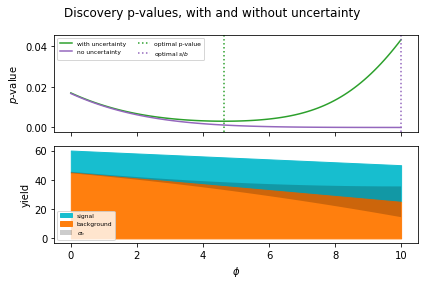

In [3]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(phis, pvals, label="with uncertainty", color="C2")
axs[0].plot(phis, pvals_no_uncertainty, label="no uncertainty", color="C4")
axs[0].set_ylabel("$p$-value")
# plot vertical dotted line at minimum of p-values + s/b
best_phi = phis[jnp.argmin(pvals)]
axs[0].axvline(x=best_phi, linestyle="dotted", color="C2", label="optimal p-value")
axs[0].axvline(
    x=phis[jnp.argmin(pvals_no_uncertainty)],
    linestyle="dotted",
    color="C4",
    label=r"optimal $s/b$",
)
axs[0].legend(loc="upper left", ncol=2)
s, b, db = ys
s, b, db = s.ravel(), b.ravel(), db.ravel()  # everything is [[x]] for pyhf
axs[1].fill_between(phis, s + b, b, color="C9", label="signal")
axs[1].fill_between(phis, b, color="C1", label="background")
axs[1].fill_between(phis, b - db, b + db, facecolor="k", alpha=0.2, label=r"$\sigma_b$")
axs[1].set_xlabel("$\phi$")
axs[1].set_ylabel("yield")
axs[1].legend(loc="lower left")
plt.suptitle("Discovery p-values, with and without uncertainty")
plt.tight_layout()

Using gradient descent, we can optimise this analysis in an uncertainty-aware way by directly optimising $\phi$ for the lowest discovery p-value. Here's how you do that:

In [4]:
# The fast way!
# use the OptaxSolver wrapper from jaxopt to perform the minimisation
# set a couple of tolerance kwargs to make sure we don't get stuck
solver = OptaxSolver(pipeline, opt=optax.adam(1e-3), tol=1e-8, maxiter=10000)
pars = 9.0  # random init
result = solver.run(pars).params
print(
    f"our solution: phi={result:.5f}\ntrue optimum: phi={phis[jnp.argmin(pvals)]:.5f}\nbest s/b:     phi=10"
)

our solution: phi=4.63643
true optimum: phi=4.64646
best s/b:     phi=10


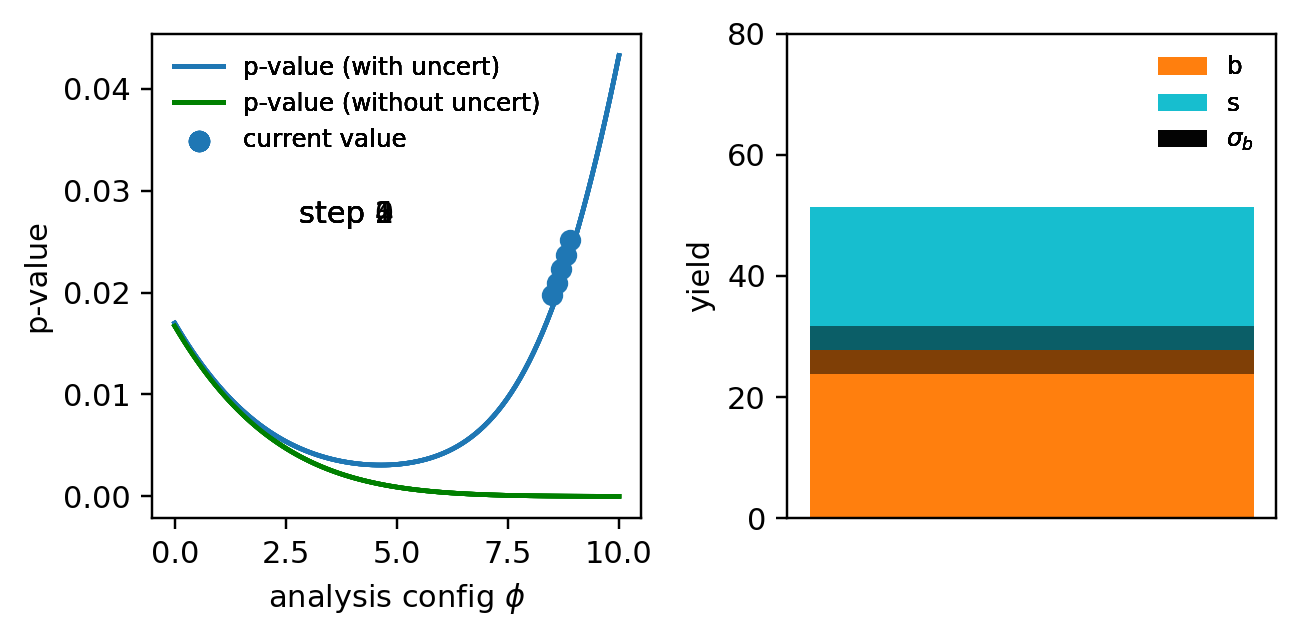

In [5]:
# The longer way (but with plots)!
pipe = partial(pipeline, return_yields=True, uncertainty=True)
solver = OptaxSolver(pipe, opt=optax.adam(1e-1), has_aux=True)
pars = 9.0
state = solver.init_state(pars)  # we're doing init, update steps instead of .run()

plt.rc("figure", figsize=(6, 3), dpi=220, facecolor="w")
plt.rc("legend", fontsize=8)
fig, axs = plt.subplots(1, 2)
cam = Camera(fig)
steps = 5  # increase me for better results! (100ish works well)
for i in range(steps):
    pars, state = solver.update(pars, state)
    s, b, db = state.aux
    val = state.value
    ax = axs[0]
    cv = ax.plot(phis, pvals, c="C0")
    cvs = ax.plot(phis, pvals_no_uncertainty, c="green")
    current = ax.scatter(pars, val, c="C0")
    ax.set_xlabel(r"analysis config $\phi$")
    ax.set_ylabel("p-value")
    ax.legend(
        [
            mlines.Line2D([], [], color="C0"),
            mlines.Line2D([], [], color="green"),
            current,
        ],
        ["p-value (with uncert)", "p-value (without uncert)", "current value"],
        frameon=False,
    )
    ax.text(0.3, 0.61, f"step {i}", transform=ax.transAxes)
    ax = axs[1]
    ax.set_ylim((0, 80))
    b1 = ax.bar(0.5, b, facecolor="C1", label="b")
    b2 = ax.bar(0.5, s, bottom=b, facecolor="C9", label="s")
    b3 = ax.bar(
        0.5, db, bottom=b - db / 2, facecolor="k", alpha=0.5, label=r"$\sigma_b$"
    )
    ax.set_ylabel("yield")
    ax.set_xticks([])
    ax.legend([b1, b2, b3], ["b", "s", r"$\sigma_b$"], frameon=False)
    plt.tight_layout()
    cam.snap()

ani = cam.animate()
# uncomment this to save and view the animation!
ani.save("ap00.gif", fps=9)